[load_image_data] Loading dataset with dimensions: {'T': (0, 120), 'Z': (0, 1), 'C': (0, 1), 'X': (0, 332), 'Y': (0, 332)}


Reading sublocks planes: 120 2Dplanes [00:00, 800.70 2Dplanes/s]
c:\Users\amarcosv\AppData\Local\miniforge3\envs\frap_analysis\lib\site-packages\skimage\filters\rank\generic.py:332: UserWarning: Bad rank filter performance is expected due to a large number of bins (1916), equivalent to an approximate bitdepth of 10.9.
  image, footprint, out, mask, n_bins = _preprocess_input(


[photobleaching_corr] Calculating photobleaching from imaging using control_wcell reference region
	using data from frame 20 onwards (10 after roi bleaching)
[np.float64(806.4611931607644), np.float64(209.31134990795147), 0.05]
([np.float64(403.2305965803822), np.float64(104.65567495397573), 0], [np.float64(1612.9223863215288), np.float64(313.9670248619272), 10])
Fit results:
	offset = 526.1842478204396
	amplitude: 313.96702315611776
	tau: 0.013680298404812222
	Fitting error (r2)= 0.6055839072217755
	Fitting goodness (chi2)= 1.0309278350554156
	Fitting significance (p-value)= 0.3970571785863125
Fitting recovery model
Fit results:
	offset = 0.6284622757518727
	amplitude: -0.44217586858280294
	tau: 0.26492920466458514
	Fitting error (r2)= 0.9702947201824252
	Fitting goodness (chi2)= 1.02803738317757
	Fitting significance (p-value)= 0.4018052023417892

FRAP results:
	Half maximum = 2.6163487012974183 [s]
	Bleach depth 0.1740130835559236
	Gap Ratio= 0.8256710265159967
	Mobile Fraction (unc

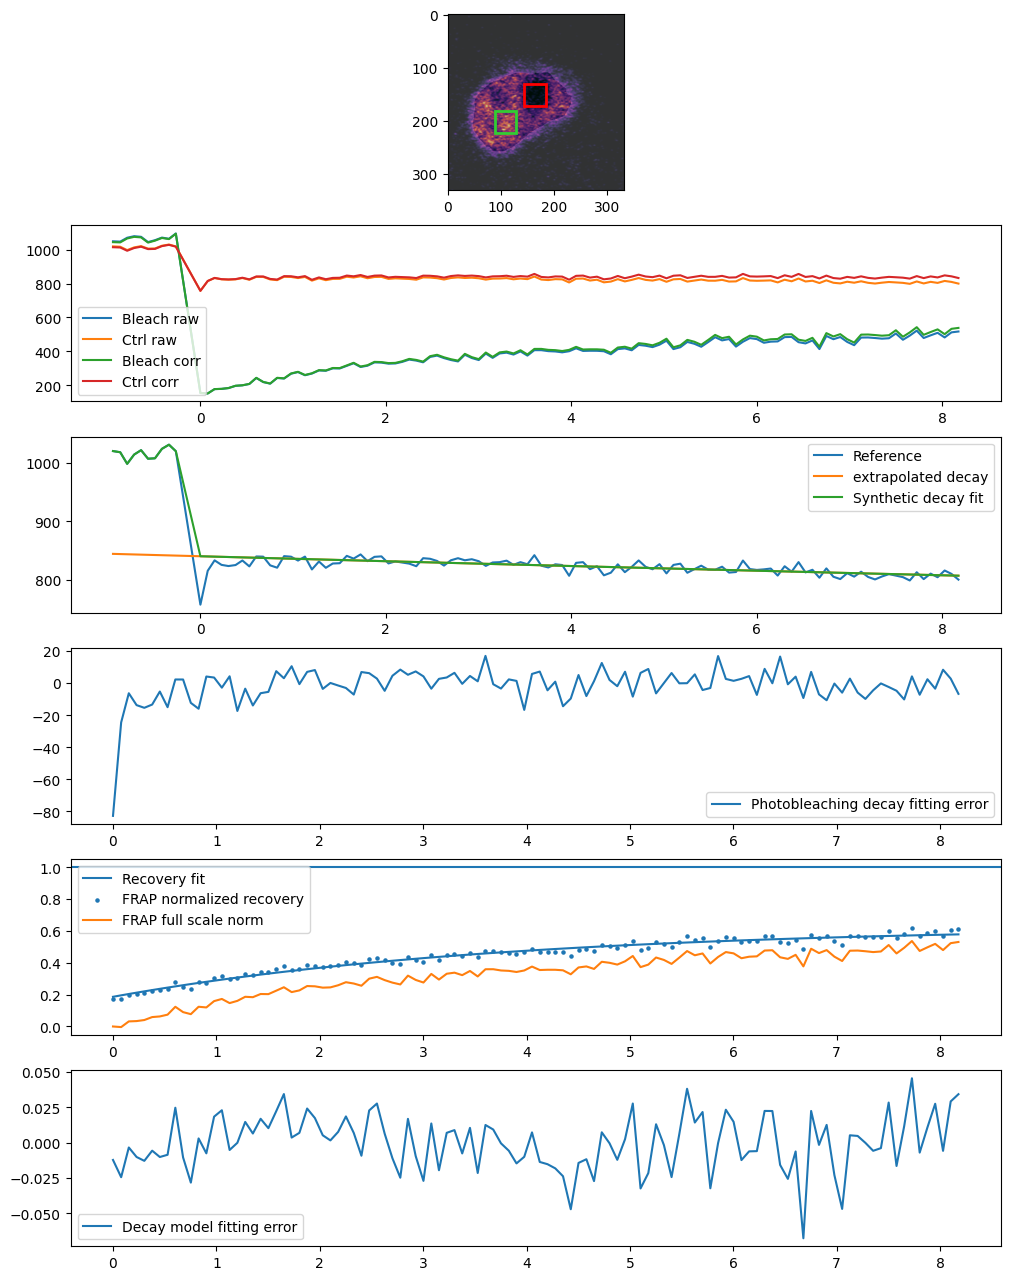

' mdata = CziMetadata(imPath)\nczimd_complete = get_metadata_as_object(imPath)\nmdata_dict = obj2dict(mdata)\ndf_md = misc.md2dataframe(mdata_dict)\n#print(df_md)\n\nfrom pylibCZIrw import czi as pyczi\n\nwith pyczi.open_czi(imPath) as czidoc:\n    md_xml = czidoc.raw_metadata\n    root = ET.fromstring(md_xml)\n    #print(md_xml)\n#meta = img.metadata\nprint("Parsing metadata")sss\nfor child in root:\n    print(child.tag, child.attrib)\n#root = meta\n#ome_meta = img.ome_metadata\n#img.data\nfor neighbor in root.iter(\'RegionItem\'):\n    print(neighbor.attrib)\n\nregions = pd.read_xml(StringIO(md_xml), xpath=".//RegionItem", attrs_only = True, parser="etree")    '

In [74]:
%reload_ext autoreload
%autoreload 2

import tools.io_tools as io_tools
import tools.processing_tools as processing_tools
import tools.frap_tools as frap_tools
from matplotlib import pyplot as plt
import pandas as pd
import matplotlib.patches as patches
from skimage.color import label2rgb 

#import bioio_czi

imPath = "D:\\Projects\\Shannon\\FRAP analysis\\images\\test\\dish1_ASS1WT_0mMH2O2_0mMNAC-#roi-09-Airyscan Processing-02.czi"
#imPath = "D:\\Projects\Shannon\\FRAP analysis\\images\\20250115_MeCP2_FRAP_processed\\dish1_MECP2WT-#roi-07-Airyscan Processing-07.czi"
imPath = "Z:\\Shannon\\20250226_MeCP2\\MUT\\dish7_MECP2MUT-#roi-08-Airyscan Processing-19.czi"
imPath = "D:\\Projects\\Shannon\\FRAP analysis\\images\\20250115_MeCP2_FRAP_processed\\WT\\dish5_MECP2WT-#roi-05-Airyscan Processing-77.czi"


roiData,regions, image, frap_experiment = frap_tools.import_FRAP_data(imPath, True)
roiData, frap_experiment = frap_tools.run_FRAP_analysis(roiData, frap_experiment, 1)

#for region in regions.iterrows():
#    print(region)

#roiData, frap_experiment = processing_tools.photobleaching_corr(roiData, 'control_roi' , frap_experiment, delay = 10,exp=1)

#roiData, frap_experiment = processing_tools.pre_bleach_normalization(roiData,'control_roi' , frap_experiment)

#roiData, frap_experiment = processing_tools.fit_recovery_curve(roiData, frap_experiment, exp=2)




print('\nFRAP results:')
if frap_experiment['recovery_model'].item()==1:
    print('\tHalf maximum = ' + str(frap_experiment['half_max'].item()) + ' [s]')
else:
    print('\tHalf maximum slow = ' + str(frap_experiment['half_max'].item()[0]) + ' [s]')
    print('\tHalf maximum fast = ' + str(frap_experiment['half_max'].item()[1]) + ' [s]')
    
print('\tBleach depth ' + str(frap_experiment['bleach_depth'].item()))
print('\tGap Ratio= ' + str(frap_experiment['gap_ratio'].item()))
print('\tMobile Fraction (uncorrected) = ' + str(frap_experiment['mob_corr'].item()) + ' (' + str(frap_experiment['mob'].item()) + ')')


rect = patches.Rectangle((regions.X_roi[1], regions.Y_roi[1]), regions.Width_roi[1], regions.Height_roi[1], linewidth=2, 
                         edgecolor=regions.Color[1], facecolor="none")
 
rect2 = patches.Rectangle((regions.X_roi[0], regions.Y_roi[0]), regions.Width_roi[0], regions.Height_roi[0], linewidth=2, 
                         edgecolor=regions.Color[0], facecolor="none")

#rect = patches.Rectangle((100, 100), 50, 50, linewidth=1, edgecolor='r', facecolor="none") 
  

# Add the patch to the Axes 
fig, ax = plt.subplots(6, figsize=(12, 16)) 

#Display sample image after photobleaching
ax[0].imshow(image[11,:,:],cmap='magma')

if frap_experiment.wcell_corr.item():
    mask = frap_experiment['wcellMask'].values[0]
    ax[0].imshow(mask.astype(int), cmap='Greens', alpha=0.2) 
 
ax[0].add_patch(rect)
ax[0].add_patch(rect2)  

#Plot raw and bleaching corrected data
ax[1].plot(roiData['timestamp_frap'],roiData['bleach'])
ax[1].plot(roiData['timestamp_frap'],roiData['reference'])
#ax[1].plot(roiData['timestamp_frap'],roiData['reference_decay_curve'])
ax[1].plot(roiData['timestamp_frap'],roiData['bleach_photo_corr'])
ax[1].plot(roiData['timestamp_frap'],roiData['reference_photo_corr'])
#ax[1].plot(roiData['timestamp_frap'],roiData['reference_synth'])

ax[1].legend(['Bleach raw', 'Ctrl raw', 'Bleach corr', 'Ctrl corr'])

#Plot photobleaching correction
ax[2].plot(roiData['timestamp_frap'],roiData['reference'])
ax[2].plot(roiData['timestamp_frap'],roiData['reference_decay_curve'])
ax[2].plot(roiData['timestamp_frap'],roiData['reference_synth'])
ax[2].legend(['Reference', 'extrapolated decay', 'Synthetic decay fit'])

#Plot photobleaching correction estimation error
ax[3].plot(roiData['timestamp_frap'].iloc[frap_experiment.bleach_frame.item() ::], 
           roiData['reference'].iloc[frap_experiment.bleach_frame.item() ::]-roiData['reference_decay_curve'].iloc[frap_experiment.bleach_frame.item() ::])
ax[3].legend(['Photobleaching decay fitting error'])

#Plot photobleaching error
#ax[4].scatter(roiData['timestamp_frap'].iloc[frap_experiment.bleach_frame.item() ::],
#           roiData['bleach_photo_corr_norm'].iloc[frap_experiment.bleach_frame.item() ::], s=5)
#ax[4].plot(roiData['timestamp_frap'].iloc[frap_experiment.bleach_frame.item() ::],
           #roiData['reference_photo_corr_norm'].iloc[frap_experiment.bleach_frame.item() ::])
ax[4].plot(roiData['timestamp_frap'].iloc[frap_experiment.bleach_frame.item() ::],
           roiData['bleach_recovery_curve'].iloc[frap_experiment.bleach_frame.item() ::])
ax[4].scatter(roiData['timestamp_frap'].iloc[frap_experiment.bleach_frame.item() ::],
           roiData['frap_norm'].iloc[frap_experiment.bleach_frame.item() ::], s=5)
ax[4].plot(roiData['timestamp_frap'].iloc[frap_experiment.bleach_frame.item() ::],
           roiData['frap_fullscale_norm'].iloc[frap_experiment.bleach_frame.item() ::])
ax[4].axhline(y=1) 
ax[4].legend([ 'Recovery fit','FRAP normalized recovery', 'FRAP full scale norm'])
#ax[4].legend(['Normalized recovery', 'Recovery fit','FRAP norm', 'FRAP full scale norm'])

ax[5].plot(roiData['timestamp_frap'].iloc[frap_experiment.bleach_frame.item() ::],
          roiData['frap_norm'].iloc[frap_experiment.bleach_frame.item() ::]-roiData['bleach_recovery_curve'].iloc[frap_experiment.bleach_frame.item() ::])
ax[5].legend(['Decay model fitting error'])
#ax[4].plot(roiData['timestamp_frap'].iloc[frap_experiment.bleach_frame.item() ::], 
#           roiData['control_wcell'].iloc[frap_experiment.bleach_frame.item() ::])
plt.show() 

#fig, ax2 = plt.subplots( figsize=(12, 10)) 



""" mdata = CziMetadata(imPath)
czimd_complete = get_metadata_as_object(imPath)
mdata_dict = obj2dict(mdata)
df_md = misc.md2dataframe(mdata_dict)
#print(df_md)

from pylibCZIrw import czi as pyczi

with pyczi.open_czi(imPath) as czidoc:
    md_xml = czidoc.raw_metadata
    root = ET.fromstring(md_xml)
    #print(md_xml)
#meta = img.metadata
print("Parsing metadata")sss
for child in root:
    print(child.tag, child.attrib)
#root = meta
#ome_meta = img.ome_metadata
#img.data
for neighbor in root.iter('RegionItem'):
    print(neighbor.attrib)

regions = pd.read_xml(StringIO(md_xml), xpath=".//RegionItem", attrs_only = True, parser="etree")    """


In [ ]:
print(frap_experiment['half_max'].item())
if frap_experiment['recovery_model'].item()==1:
    print('\tHalf maximum = ' + str(frap_experiment['half_max'].item()) + '[s]')
else:
    print('\tHalf maximum slow = ' + str(frap_experiment['half_max'].item()[0]) + '[s]')
    print('\tHalf maximum fast = ' + str(frap_experiment['half_max'].item()[1]) + '[s]')

[ 1.84280035 53.11671539]
	Half maximum slow = 1.842800353505995[s]
	Half maximum fast = 53.116715391645066[s]


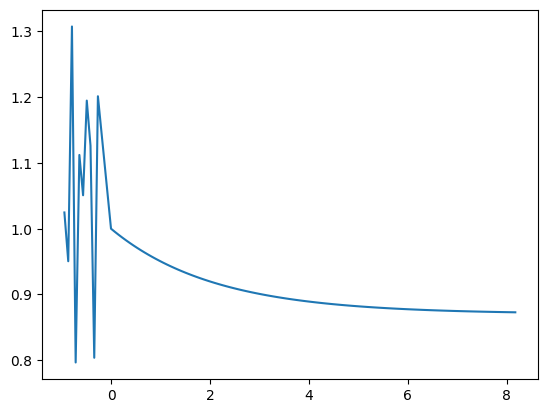

In [ ]:
plt.plot(roiData['timestamp_frap'],roiData['ref_norm'])
#plt.plot(roiData['timestamp_frap'],roiData['reference_photo_corr'])
#plt.plot(roiData['timestamp_frap'],roiData['reference'])
plt.show()